# Neural Network Experiments: MNIST and MB Dataset Classification

**Final Project - Introduction to Machine Learning**

This notebook demonstrates a fully connected feed-forward neural network implementation for two different classification tasks:
1. **MNIST Digit Classification** - Multi-class classification of handwritten digits
2. **MB Dataset Classification** - Binary classification for medical data (Control vs Fibrosis)
3. **Denoising using Autoencoder**

## Overview
- Custom neural network implementation with ReLU activation and softmax output
- Mini-batch gradient descent with cross-entropy loss
- Hyperparameter optimization using smart phased sampling
- Comprehensive evaluation and visualization of results

## Setup and Imports

In [14]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Setup complete!")
print(f"Current working directory: {os.getcwd()}")

Setup complete!
Current working directory: /Users/naamaavni/workspace/naama/intro_to_ml/final_project


## A. Neural Network Implementation

In [18]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, epochs=100, batch_size=32, weight_decay=0.001):
        """
        Initialize a fully connected feed-forward neural network
        
        Args:
            layer_sizes: List of integers representing the number of neurons in each layer
            learning_rate: Learning rate for gradient descent
            epochs: Number of training epochs
            batch_size: Size of mini-batches for training
            weight_decay: L2 regularization coefficient (default: 0.001)
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay  # Add this line
        self.weights = []
        self.biases = []
        self.initialize_parameters()
        
    def initialize_parameters(self):
        """Initialize weights and biases for all layers"""
        for i in range(len(self.layer_sizes) - 1):
            # He initialization for better gradient flow
            w = np.random.randn(self.layer_sizes[i+1], self.layer_sizes[i]) * np.sqrt(2.0 / self.layer_sizes[i])
            b = np.zeros((self.layer_sizes[i+1], 1))
            self.weights.append(w)
            self.biases.append(b)
    
    def sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def sigmoid_derivative(self, z):
        """Derivative of sigmoid function"""
        s = self.sigmoid(z)
        return s * (1 - s)
    
    def relu(self, z):
        """ReLU activation function"""
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        """Derivative of ReLU function"""
        return np.where(z > 0, 1, 0)
    
    def softmax(self, z):
        """Softmax activation function for output layer"""
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def forward_propagation(self, X):
        """Forward propagation through the network"""
        activations = [X]
        z_values = []
        
        # Hidden layers with ReLU activation
        for i in range(len(self.weights) - 1):
            z = np.dot(self.weights[i], activations[-1]) + self.biases[i]
            z_values.append(z)
            activation = self.relu(z)
            activations.append(activation)
        
        # Output layer with softmax activation
        z = np.dot(self.weights[-1], activations[-1]) + self.biases[-1]
        z_values.append(z)
        activation = self.softmax(z)
        activations.append(activation)
        
        return activations, z_values
    
    def backward_propagation(self, X, y, activations, z_values):
        """Backward propagation to compute gradients"""
        m = X.shape[1]
        delta = activations[-1] - y  # Error at output layer
        
        weight_gradients = []
        bias_gradients = []
        
        # Backpropagate through layers
        for i in range(len(self.weights) - 1, -1, -1):
            # Compute gradients for weights and biases
            dW = np.dot(delta, activations[i].T) / m
            db = np.sum(delta, axis=1, keepdims=True) / m
            
            weight_gradients.insert(0, dW)
            bias_gradients.insert(0, db)
            
            # Compute delta for next layer (if not at input layer)
            if i > 0:
                delta = np.dot(self.weights[i].T, delta) * self.relu_derivative(z_values[i-1])
        
        return weight_gradients, bias_gradients
    
    def update_parameters(self, weight_gradients, bias_gradients):
        """Update weights and biases using gradient descent with weight decay."""
        for i in range(len(self.weights)):
            # Add weight decay to weight gradients
            weight_gradients[i] += self.weight_decay * self.weights[i]
            
            self.weights[i] -= self.learning_rate * weight_gradients[i]
            self.biases[i] -= self.learning_rate * bias_gradients[i]
    
    def one_hot_encode(self, y, num_classes):
        """Convert labels to one-hot encoding"""
        m = y.shape[0]
        y_one_hot = np.zeros((num_classes, m))
        y_one_hot[y, np.arange(m)] = 1
        return y_one_hot
    
    def fit(self, X, y, X_val=None, y_val=None, patience=10, verbose=True):
        """
        Train the neural network with early stopping
        
        Args:
            X: Training features (n_features, n_samples)
            y: Training labels (n_samples,)
            X_val: Validation features (optional, for early stopping)
            y_val: Validation labels (optional, for early stopping)
            patience: Number of epochs to wait before early stopping
            verbose: Whether to print training progress
        """
        # Ensure X is in correct format (features x samples)
        if X.shape[0] != self.layer_sizes[0]:
            X = X.T
        
        # One-hot encode the labels
        num_classes = self.layer_sizes[-1]
        y_one_hot = self.one_hot_encode(y, num_classes)
        
        # Training history
        self.training_loss = []
        self.validation_loss = []
        self.validation_accuracy = []
        
        # Early stopping variables
        best_val_accuracy = 0
        epochs_without_improvement = 0
        best_weights = None
        best_biases = None
        
        if verbose:
            print(f"Training neural network with {self.epochs} epochs...")
            if X_val is not None:
                print(f"Early stopping enabled with patience={patience}")
            if self.weight_decay > 0:
                print(f"Weight decay enabled: {self.weight_decay}")
        
        start_time = time.time()
        
        for epoch in range(self.epochs):
            # Mini-batch training
            indices = np.random.permutation(X.shape[1])
            total_loss = 0
            
            for i in range(0, X.shape[1], self.batch_size):
                batch_indices = indices[i:i+self.batch_size]
                X_batch = X[:, batch_indices]
                y_batch = y_one_hot[:, batch_indices]
                
                # Forward propagation
                activations, z_values = self.forward_propagation(X_batch)
                
                # Compute loss (cross-entropy + weight decay)
                cross_entropy_loss = -np.mean(np.sum(y_batch * np.log(activations[-1] + 1e-15), axis=0))
                
                # Add weight decay penalty
                weight_decay_loss = 0
                for w in self.weights:
                    weight_decay_loss += 0.5 * self.weight_decay * np.sum(w**2)
                
                total_loss = cross_entropy_loss + weight_decay_loss
                total_loss += total_loss
                
                # Backward propagation
                weight_gradients, bias_gradients = self.backward_propagation(X_batch, y_batch, activations, z_values)
                
                # Update parameters (weight decay is added in update_parameters)
                self.update_parameters(weight_gradients, bias_gradients)
            
            avg_loss = total_loss / (X.shape[1] // self.batch_size + 1)
            self.training_loss.append(avg_loss)
            
            # Validation and early stopping
            if X_val is not None:
                # Ensure validation data is in correct format
                if X_val.shape[0] != self.layer_sizes[0]:
                    X_val_formatted = X_val.T
                else:
                    X_val_formatted = X_val
                
                # Compute validation loss and accuracy
                val_activations, _ = self.forward_propagation(X_val_formatted)
                val_loss = -np.mean(np.sum(self.one_hot_encode(y_val, num_classes) * 
                                        np.log(val_activations[-1] + 1e-15), axis=0))
                val_accuracy = self.score(X_val, y_val)
                
                self.validation_loss.append(val_loss)
                self.validation_accuracy.append(val_accuracy)
                
                # Check for improvement
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    epochs_without_improvement = 0
                    # Save best model
                    best_weights = [w.copy() for w in self.weights]
                    best_biases = [b.copy() for b in self.biases]
                else:
                    epochs_without_improvement += 1
                
                # Early stopping check
                if epochs_without_improvement >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
                    # Restore best model
                    self.weights = best_weights
                    self.biases = best_biases
                    break
                
                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}/{self.epochs}, Train Loss: {avg_loss:.4f}, "
                        f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
            else:
                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}/{self.epochs}, Loss: {avg_loss:.4f}")
        
        training_time = time.time() - start_time
        if verbose:
            print(f"Training completed in {training_time:.2f} seconds")
            print(f"Final training loss: {self.training_loss[-1]:.4f}")
            if X_val is not None:
                print(f"Best validation accuracy: {best_val_accuracy:.4f}")
        
        return training_time
    
    def predict(self, X):
        """
        Make predictions on new data
        
        Args:
            X: Input features (n_features, n_samples) or (n_samples, n_features)
        
        Returns:
            predictions: Predicted class labels
        """
        # Ensure X is in correct format
        if X.shape[0] != self.layer_sizes[0]:
            X = X.T
        
        # Forward propagation
        activations, _ = self.forward_propagation(X)
        
        # Return predicted class (argmax of softmax output)
        predictions = np.argmax(activations[-1], axis=0)
        return predictions
    
    def score(self, X, y):
        """
        Calculate accuracy score
        
        Args:
            X: Test features
            y: True labels
        
        Returns:
            accuracy: Accuracy score between 0 and 1
        """
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)
        return accuracy
    
    def plot_training_loss(self, save_path=None):
        """Plot the training loss over epochs"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.training_loss)
        plt.title('Training Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Training loss plot saved to: {save_path}")
        else:
            plt.show()
        plt.close() 

## Experiment 1: MNIST Digit Classification

### Data Loading and Preprocessing

In [22]:
def load_mnist_data():
    """Load and preprocess MNIST dataset"""
        
    # Load training data
    print("Loading training data...")
    train_data = pd.read_csv("./MNIST-train.csv")
    print(f"Training data shape: {train_data.shape}")
    
    # Load test data
    print("Loading test data...")
    test_data = pd.read_csv("./MNIST-test.csv")
    print(f"Test data shape: {test_data.shape}")
    
    # Separate features and labels using 'y' column
    X_train_full = train_data.drop('y', axis=1).values  # All columns except 'y'
    y_train_full = train_data['y'].values               # 'y' column (labels)
    
    X_test = test_data.drop('y', axis=1).values    # All columns except 'y'
    y_test = test_data['y'].values                 # 'y' column (labels)
    
    # Split training data into train and validation sets (80/20 split)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )
    
    # Normalize pixel values to [0, 1]
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0
    
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")
    print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    print(f"Number of classes: {len(np.unique(y_train))}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Load MNIST data
print("Loading MNIST dataset...")
X_train, X_val, X_test, y_train, y_val, y_test = load_mnist_data()

print(f"\nMNIST Dataset Summary:")
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"Class distribution: {np.bincount(y_test)}")

Loading MNIST dataset...
Loading training data...
Training data shape: (60000, 785)
Loading test data...
Test data shape: (10000, 785)
Training set: 48000 samples, 784 features
Validation set: 12000 samples, 784 features
Test set: 10000 samples, 784 features
Number of classes: 10

MNIST Dataset Summary:
Training set: 48000 samples, 784 features
Test set: 10000 samples, 784 features
Number of classes: 10
Class distribution: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


## B. Process MNIST using NeuralNetwork

MNIST NEURAL NETWORK
Loading MNIST dataset...
Loading training data...
Training data shape: (60000, 785)
Loading test data...
Test data shape: (10000, 785)
Training set: 48000 samples, 784 features
Validation set: 12000 samples, 784 features
Test set: 10000 samples, 784 features
Number of classes: 10

Dataset Summary:
Training set: 48000 samples, 784 features
Validation set: 12000 samples, 784 features
Test set: 10000 samples, 784 features
Number of classes: 10

Network Architecture: [784, 64, 32, 10]
Input size: 784
Hidden layers: [64, 32]
Output size: 10

Creating neural network...
Network created successfully!
Total parameters: 52,650

Starting training...
Training neural network with 20 epochs...
Weight decay enabled: 0.001
Epoch 0/20, Loss: 0.0007
Epoch 10/20, Loss: 0.0003
Training completed in 85.12 seconds
Final training loss: 0.0002
Training completed successfully in 85.12 seconds!

Evaluating model...
Training Accuracy: 0.9756 (97.56%)
Validation Accuracy: 0.9631 (96.31%)
Test

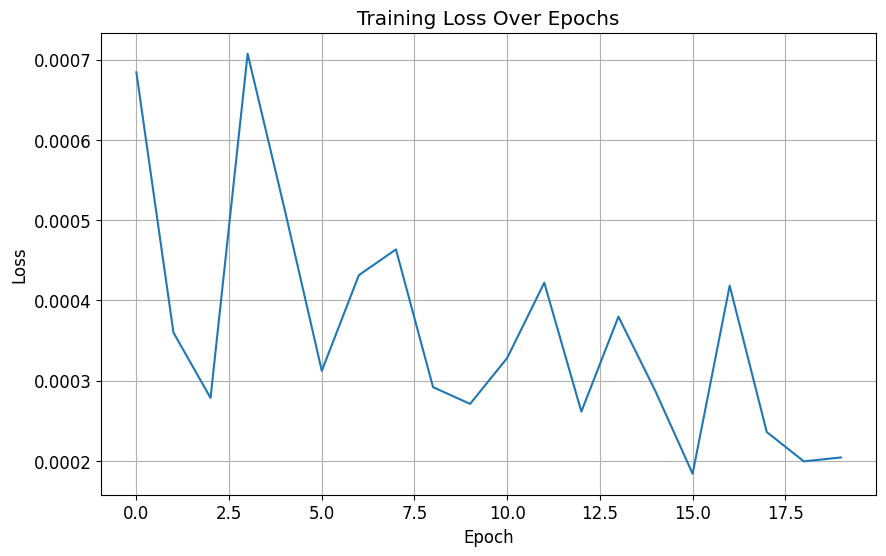


Testing predictions on a few samples...
Sample 1: Predicted 4, True 4
Sample 2: Predicted 6, True 6
Sample 3: Predicted 5, True 8
Sample 4: Predicted 8, True 8
Sample 5: Predicted 3, True 3

COMPLETED SUCCESSFULLY!
Training Accuracy: 0.9756 (97.56%)
Validation Accuracy: 0.9631 (96.31%)
Test Accuracy: 0.9647 (96.47%)
Training time: 85.12 seconds


In [23]:
def mnist_main():
    """Main function runs NeuralNetwork on MNIST"""
    print("=" * 60)
    print("MNIST NEURAL NETWORK")
    print("=" * 60)
    
    # Load MNIST data
    print("Loading MNIST dataset...")
    X_train, X_val, X_test, y_train, y_val, y_test = load_mnist_data()
    
    print(f"\nDataset Summary:")
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")
    print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    print(f"Number of classes: {len(np.unique(y_train))}")
    
    # Define network architecture
    input_size = X_train.shape[1]  # 784 features
    num_classes = len(np.unique(y_train))  # 10 classes
    architecture = [input_size, 64, 32, num_classes]  # Simple 2-hidden layer network
    
    print(f"\nNetwork Architecture: {architecture}")
    print(f"Input size: {input_size}")
    print(f"Hidden layers: {architecture[1:-1]}")
    print(f"Output size: {num_classes}")
    
    # Create and train neural network
    print(f"\nCreating neural network...")
    nn = NeuralNetwork(
        layer_sizes=architecture,
        learning_rate=0.01,
        epochs=20,  # Reduced epochs for faster testing
        batch_size=32
    )
    
    print(f"Network created successfully!")
    print(f"Total parameters: {sum(w.size + b.size for w, b in zip(nn.weights, nn.biases)):,}")
    
    # Train the network
    print(f"\nStarting training...")
    try:
        training_time = nn.fit(X_train, y_train, verbose=True)
        print(f"Training completed successfully in {training_time:.2f} seconds!")
        
        # Evaluate on training and validation sets
        print(f"\nEvaluating model...")
        train_accuracy = nn.score(X_train, y_train)
        val_accuracy = nn.score(X_val, y_val)
        test_accuracy = nn.score(X_test, y_test)
        
        print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
        print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        
        # Plot training loss
        print(f"\nPlotting training loss...")
        nn.plot_training_loss()
        
        # Test some predictions
        print(f"\nTesting predictions on a few samples...")
        sample_indices = np.random.choice(len(X_val), 5, replace=False)
        for i, idx in enumerate(sample_indices):
            prediction = nn.predict(X_val[idx:idx+1])
            true_label = y_val[idx]
            print(f"Sample {i+1}: Predicted {prediction[0]}, True {true_label}")
        
        print(f"\n" + "=" * 60)
        print("COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
        print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        print(f"Training time: {training_time:.2f} seconds")
        
        
    except Exception as e:
        print(f"\nERROR during training: {str(e)}")
        import traceback
        traceback.print_exc()


mnist_main() 

## C. Hyperparameter Optimization 

Starting simple hyperparameter optimization...
Loading training data...
Training data shape: (60000, 785)
Loading test data...
Test data shape: (10000, 785)
Training set: 48000 samples, 784 features
Validation set: 12000 samples, 784 features
Test set: 10000 samples, 784 features
Number of classes: 10
Using 2000 training samples and 500 validation samples for optimization
HYPERPARAMETER OPTIMIZATION
Testing 10 combinations...
Architectures: 4
Learning rates: [0.001, 0.01, 0.1]
Epochs: [20, 30, 50]
Batch sizes: [16, 32, 64]

--- Trial 1/10 ---
Architecture: [784, 64, 32, 10]
Learning Rate: 0.01
Epochs: 20
Batch Size: 16
Validation Accuracy: 0.8820 (88.20%)
Training Time: 2.42s
Total Parameters: 52,650
*** NEW BEST CONFIGURATION! ***

--- Trial 2/10 ---
Architecture: [784, 64, 32, 10]
Learning Rate: 0.001
Epochs: 50
Batch Size: 32
Validation Accuracy: 0.7920 (79.20%)
Training Time: 3.36s
Total Parameters: 52,650

--- Trial 3/10 ---
Architecture: [784, 64, 32, 10]
Learning Rate: 0.001
Epo

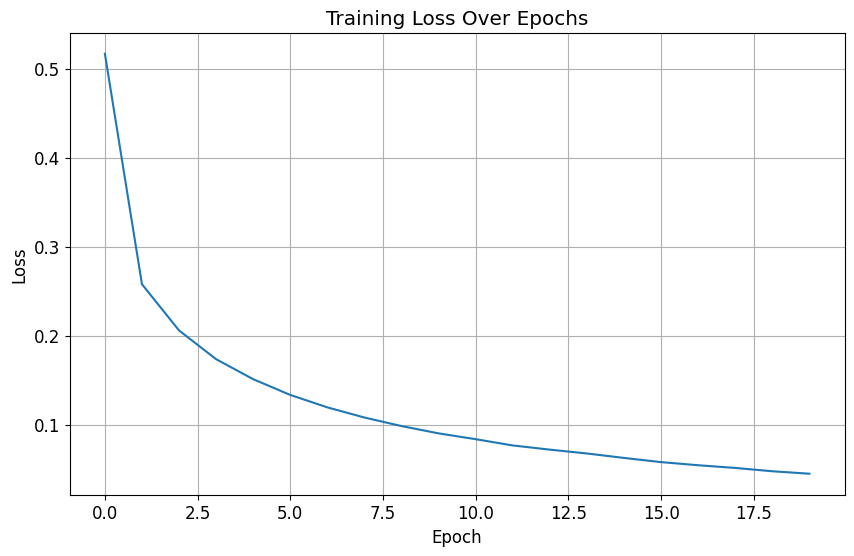

({'trial': 1,
  'architecture': [784, 64, 32, 10],
  'learning_rate': 0.01,
  'epochs': 20,
  'batch_size': 16,
  'val_accuracy': 0.882,
  'training_time': 2.4172399044036865,
  'total_params': 52650},
 <__main__.NeuralNetwork at 0x125247150>)

In [61]:
def optimize_hyperparameters(X_train, y_train, X_val, y_val, max_trials=10):
    """
    Hyperparameter optimization
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        max_trials: Maximum number of trials
    
    Returns:
        best_config: Best hyperparameter configuration
        results: List of all trial results
    """
    print("=" * 60)
    print("HYPERPARAMETER OPTIMIZATION")
    print("=" * 60)
    
    # Define hyperparameter search space
    input_size = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    # architectures to try
    architectures = [
        [input_size, 64, 32, num_classes],           # Small network
        [input_size, 128, 64, num_classes],          # Medium network
        [input_size, 256, 128, 64, num_classes],     # Large network
        [input_size, 128, 128, num_classes],         # Wide network
    ]
    
    # Learning rates to try
    learning_rates = [0.001, 0.01, 0.1]
    
    # Epochs to try
    epochs_list = [20, 30, 50]
    
    # Batch sizes to try
    batch_sizes = [16, 32, 64]
    
    # Generate combinations
    combinations = []
    
    # Test each architecture with different learning rates
    for arch in architectures:
        for lr in learning_rates:
            for epochs in epochs_list:
                for batch_size in batch_sizes:
                    if len(combinations) < max_trials:
                        combinations.append({
                            'architecture': arch,
                            'learning_rate': lr,
                            'epochs': epochs,
                            'batch_size': batch_size
                        })
    
    # Shuffle combinations to get variety
    import random
    random.shuffle(combinations)
    combinations = combinations[:max_trials]
    
    results = []
    best_accuracy = 0
    best_config = None
    
    print(f"Testing {len(combinations)} combinations...")
    print(f"Architectures: {len(architectures)}")
    print(f"Learning rates: {learning_rates}")
    print(f"Epochs: {epochs_list}")
    print(f"Batch sizes: {batch_sizes}")
    
    for trial_count, combo in enumerate(combinations, 1):
        print(f"\n--- Trial {trial_count}/{len(combinations)} ---")
        print(f"Architecture: {combo['architecture']}")
        print(f"Learning Rate: {combo['learning_rate']}")
        print(f"Epochs: {combo['epochs']}")
        print(f"Batch Size: {combo['batch_size']}")
        
        # Create and train network
        try:
            nn = NeuralNetwork(
                layer_sizes=combo['architecture'],
                learning_rate=combo['learning_rate'],
                epochs=combo['epochs'],
                batch_size=combo['batch_size']
            )
            
            # Train with reduced verbosity
            training_time = nn.fit(X_train, y_train, verbose=False)
            
            # Evaluate on validation set
            val_accuracy = nn.score(X_val, y_val)
            
            # Store results
            result = {
                'trial': trial_count,
                'architecture': combo['architecture'],
                'learning_rate': combo['learning_rate'],
                'epochs': combo['epochs'],
                'batch_size': combo['batch_size'],
                'val_accuracy': val_accuracy,
                'training_time': training_time,
                'total_params': sum(w.size + b.size for w, b in zip(nn.weights, nn.biases))
            }
            
            results.append(result)
            
            print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
            print(f"Training Time: {training_time:.2f}s")
            print(f"Total Parameters: {result['total_params']:,}")
            
            # Update best configuration
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_config = result.copy()
                print("*** NEW BEST CONFIGURATION! ***")
            
        except Exception as e:
            print(f"Error in trial {trial_count}: {str(e)}")
            continue
    
    # Print summary
    print("\n" + "=" * 60)
    print("OPTIMIZATION SUMMARY")
    print("=" * 60)
    print(f"Total trials completed: {len(results)}")
    
    if best_config is None:
        print("ERROR: No successful trials completed.")
        return None, results
    
    print(f"Best validation accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    print("\nBest configuration:")
    print(f"  Architecture: {best_config['architecture']}")
    print(f"  Learning Rate: {best_config['learning_rate']}")
    print(f"  Epochs: {best_config['epochs']}")
    print(f"  Batch Size: {best_config['batch_size']}")
    print(f"  Training Time: {best_config['training_time']:.2f}s")
    print(f"  Total Parameters: {best_config['total_params']:,}")
    
    # Show top 3 configurations
    print(f"\nTop 3 configurations:")
    sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
    for i, result in enumerate(sorted_results[:3], 1):
        print(f"{i}. Accuracy: {result['val_accuracy']:.4f} - "
              f"Arch: {result['architecture']}, LR: {result['learning_rate']}, "
              f"Epochs: {result['epochs']}, Batch: {result['batch_size']}")
    
    return best_config, results

def run_optimization():
    """Run hyperparameter optimization"""
    print("Starting simple hyperparameter optimization...")
    
    # Load MNIST data
    X_train, X_val, X_test, y_train, y_val, y_test = load_mnist_data()
    
    # Use smaller subset for faster optimization
    subset_size = 2000  # Use 2000 samples for optimization
    
    X_train_small = X_train[:subset_size]
    y_train_small = y_train[:subset_size]
    X_val_small = X_val[:subset_size//4]  # 500 validation samples
    y_val_small = y_val[:subset_size//4]
    
    print(f"Using {subset_size} training samples and {subset_size//4} validation samples for optimization")
    
    # Run optimization
    best_config, results = optimize_hyperparameters(
        X_train_small, y_train_small, X_val_small, y_val_small, max_trials=10
    )
    
    if best_config is not None:
        print(f"\nOptimization completed!")
        print(f"Best configuration found:")
        print(f"  Architecture: {best_config['architecture']}")
        print(f"  Learning Rate: {best_config['learning_rate']}")
        print(f"  Epochs: {best_config['epochs']}")
        print(f"  Batch Size: {best_config['batch_size']}")
        print(f"  Best Validation Accuracy: {best_config['val_accuracy']:.4f}")
        
        # Train final model with best configuration on full dataset
        print(f"\nTraining final model with best configuration on full dataset...")
        final_nn = NeuralNetwork(
            layer_sizes=best_config['architecture'],
            learning_rate=best_config['learning_rate'],
            epochs=best_config['epochs'],
            batch_size=best_config['batch_size']
        )
        
        # Train on full dataset
        final_training_time = final_nn.fit(X_train, y_train, verbose=True)
        
        # Final evaluation
        final_train_accuracy = final_nn.score(X_train, y_train)
        final_val_accuracy = final_nn.score(X_val, y_val)
        final_test_accuracy = final_nn.score(X_test, y_test)
        
        print(f"\nFinal Results (Full Dataset):")
        print(f"Training Accuracy: {final_train_accuracy:.4f} ({final_train_accuracy*100:.2f}%)")
        print(f"Validation Accuracy: {final_val_accuracy:.4f} ({final_val_accuracy*100:.2f}%)")
        print(f"Test Accuracy: {final_test_accuracy:.4f} ({final_test_accuracy*100:.2f}%)")
        print(f"Training Time: {final_training_time:.2f}s")
        
        # Plot final training loss
        final_nn.plot_training_loss()
        
        return best_config, final_nn
    else:
        print("Optimization failed. No successful trials.")
        return None, None


run_optimization() 

## Experiment 2: MB Dataset Classification

### 2.1 Data Loading and Preprocessing

In [19]:
def load_mb_data():
    """Load and preprocess MB dataset from inputs directory"""
    
    try:
        
        # Load training data
        print("Loading MB training data...")
        train_data = pd.read_csv("./MB_data_train.csv", index_col=0)
        print(f"MB training data shape: {train_data.shape}")
        
        # Extract labels from row names
        # Pt_Fibro_* -> class 1 (Fibrosis)
        # Pt_Ctrl_* -> class 0 (Control)
        y_train = []
        for patient_id in train_data.index:
            if patient_id.startswith('Pt_Fibro_'):
                y_train.append(1)  # Fibrosis
            elif patient_id.startswith('Pt_Ctrl_'):
                y_train.append(0)  # Control
            else:
                print(f"Warning: Unknown patient type: {patient_id}")
                y_train.append(0)  # Default to control
        
        y_train = np.array(y_train)
        X_train = train_data.values
        
        # Normalize features (standard scaling)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        # Split into train and validation sets (since we only have one file)
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        
        print(f"Training set: {X_train_split.shape[0]} samples, {X_train_split.shape[1]} features")
        print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")
        print(f"Number of classes: {len(np.unique(y_train))}")
        print(f"Class distribution - Control: {np.sum(y_train == 0)}, Fibrosis: {np.sum(y_train == 1)}")
        
        return X_train_split, X_val, y_train_split, y_val
        
    except FileNotFoundError as e:
        print(f"Error: Could not find MB data file in inputs directory: {e}")
        
    except Exception as e:
        print(f"Error loading MB data: {e}")


# Load MB data
print("Loading MB dataset...")
X_train_mb, X_val_mb, y_train_mb, y_val_mb = load_mb_data()

print(f"\nMB Dataset Summary:")
print(f"Training set: {X_train_mb.shape[0]} samples, {X_train_mb.shape[1]} features")
print(f"Validation set: {X_val_mb.shape[0]} samples, {X_val_mb.shape[1]} features")
print(f"Number of classes: {len(np.unique(y_train_mb))}")
print(f"Class distribution: {np.bincount(y_train_mb)}")
print(f"Classes: 0=Control, 1=Fibrosis")

Loading MB dataset...
Loading MB training data...
MB training data shape: (100, 1620)
Training set: 80 samples, 1620 features
Validation set: 20 samples, 1620 features
Number of classes: 2
Class distribution - Control: 38, Fibrosis: 62

MB Dataset Summary:
Training set: 80 samples, 1620 features
Validation set: 20 samples, 1620 features
Number of classes: 2
Class distribution: [30 50]
Classes: 0=Control, 1=Fibrosis


## 2.2. Process MB dataset using NeuralNetwork

MB DATASET WITH REGULARIZATION
Loading MB dataset...
Loading MB training data...
MB training data shape: (100, 1620)
Training set: 80 samples, 1620 features
Validation set: 20 samples, 1620 features
Number of classes: 2
Class distribution - Control: 38, Fibrosis: 62

Dataset Summary:
Training set: 80 samples, 1620 features
Validation set: 20 samples, 1620 features
Number of classes: 2
Class distribution: [30 50]

Network Architecture: [1620, 8, 2]
Input size: 1620
Hidden layers: [8]
Output size: 2 (binary classification)

Creating neural network with regularization...
Network created successfully!
Total parameters: 12,986
Weight decay: 0.01

Starting training with early stopping...
Training neural network with 50 epochs...
Early stopping enabled with patience=5
Weight decay enabled: 0.01
Epoch 0/50, Train Loss: 0.2465, Val Loss: 0.5423, Val Acc: 0.7500
Early stopping at epoch 6 (no improvement for 5 epochs)
Training completed in 0.02 seconds
Final training loss: 0.1552
Best validation 

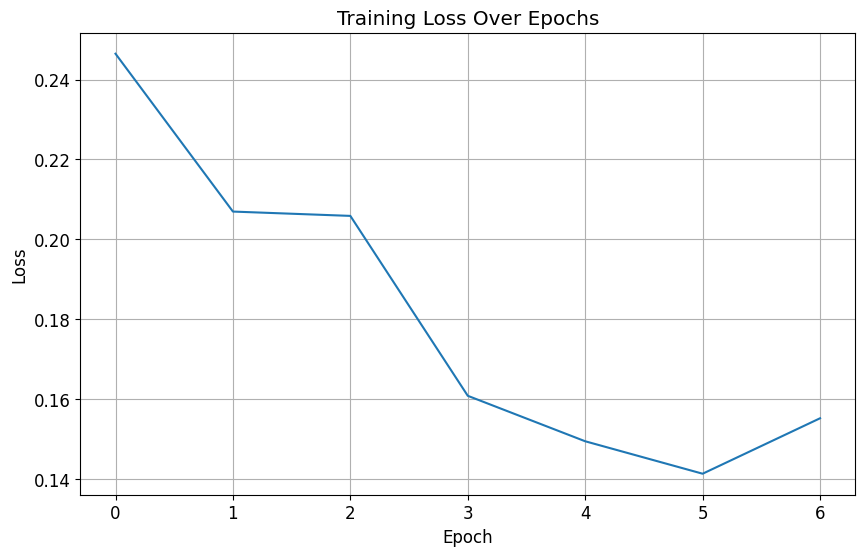


REGULARIZATION SUMMARY
Weight Decay: 0.01
Early Stopping: Enabled (patience=5)
Final Training Loss: 0.155211
Final Validation Loss: 0.496497
Best Validation Accuracy: 0.8000

MB TEST COMPLETED SUCCESSFULLY!
Training Accuracy: 0.8125 (81.25%)
Validation Accuracy: 0.8000 (80.00%)
Training time: 0.02 seconds


True

In [21]:
def mb_main():
    """NeuralNetwork on MB dataset with regularization"""
    print("=" * 60)
    print("MB DATASET WITH REGULARIZATION")
    print("=" * 60)
    
    # Load MB data
    print("Loading MB dataset...")
    X_train, X_val, y_train, y_val = load_mb_data()
    
    print(f"\nDataset Summary:")
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")
    print(f"Number of classes: {len(np.unique(y_train))}")
    print(f"Class distribution: {np.bincount(y_train)}")
    
    # Define network architecture for binary classification
    input_size = X_train.shape[1]
    num_classes = 2
    architecture = [input_size, 8, num_classes]  # Single hidden layer with only 8 neurons
    
    print(f"\nNetwork Architecture: {architecture}")
    print(f"Input size: {input_size}")
    print(f"Hidden layers: {architecture[1:-1]}")
    print(f"Output size: {num_classes} (binary classification)")
    
    # Create and train neural network with regularization
    print(f"\nCreating neural network with regularization...")
    nn = NeuralNetwork(
        layer_sizes=architecture,
        learning_rate=0.01,
        epochs=50,  # More epochs since we have early stopping
        batch_size=16,  # Smaller batch size for small dataset
        weight_decay=0.01  # Strong regularization for small dataset
    )
    
    print(f"Network created successfully!")
    print(f"Total parameters: {sum(w.size + b.size for w, b in zip(nn.weights, nn.biases)):,}")
    print(f"Weight decay: {nn.weight_decay}")
    
    # Train the network with early stopping
    print(f"\nStarting training with early stopping...")
    try:
        training_time = nn.fit(
            X_train, y_train, 
            X_val=X_val, y_val=y_val,  # Enable early stopping
            patience=5,  # Stop after 5 epochs without improvement
            verbose=True
        )
        print(f"Training completed successfully in {training_time:.2f} seconds!")
        
        # Evaluate on training and validation sets
        print(f"\nEvaluating model...")
        train_accuracy = nn.score(X_train, y_train)
        val_accuracy = nn.score(X_val, y_val)
        
        print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
        print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        
        # Plot training curves
        print(f"\nPlotting training curves...")
        nn.plot_training_loss()
        
        # Print regularization summary
        print(f"\n" + "=" * 60)
        print("REGULARIZATION SUMMARY")
        print("=" * 60)
        print(f"Weight Decay: {nn.weight_decay}")
        print(f"Early Stopping: Enabled (patience=5)")
        print(f"Final Training Loss: {nn.training_loss[-1]:.6f}")
        if hasattr(nn, 'validation_loss') and nn.validation_loss:
            print(f"Final Validation Loss: {nn.validation_loss[-1]:.6f}")
            print(f"Best Validation Accuracy: {max(nn.validation_accuracy):.4f}")
        
        print(f"\n" + "=" * 60)
        print("MB TEST COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
        print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"Training time: {training_time:.2f} seconds")
        
        return True
        
    except Exception as e:
        print(f"\nERROR during training: {str(e)}")
        import traceback
        traceback.print_exc()
        return False
    
mb_main()

## Autoencoder Implementation


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any, Optional
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.manifold import TSNE
import pandas as pd

class SimpleAutoEncoder(nn.Module):
    """
    Simple AutoEncoder with one hidden layer.
    
    Architecture:
    - Input layer -> Hidden layer (encoder)
    - Hidden layer -> Output layer (decoder)
    """
    
    def __init__(self, input_dim: int, hidden_dim: int, activation: str = 'relu'):
        """
        Initialize the simple autoencoder.
        
        Args:
            input_dim: Dimension of input data
            hidden_dim: Dimension of hidden layer (latent space)
            activation: Activation function ('relu', 'tanh', 'sigmoid')
        """
        super(SimpleAutoEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Encoder: input -> hidden
        self.encoder = nn.Linear(input_dim, hidden_dim)
        
        # Decoder: hidden -> output
        self.decoder = nn.Linear(hidden_dim, input_dim)
        
        # Activation function
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise ValueError(f"Unsupported activation: {activation}")
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode input to latent representation."""
        return self.activation(self.encoder(x))
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent representation to output."""
        return self.decoder(z)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the autoencoder.
        
        Args:
            x: Input tensor of shape (batch_size, input_dim)
            
        Returns:
            Tuple of (reconstructed_output, latent_representation)
        """
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


class SimpleAutoEncoderTrainer:
    """Trainer class for the simple autoencoder."""
    
    def __init__(self, model: SimpleAutoEncoder, learning_rate: float = 0.001):
        """
        Initialize the trainer.
        
        Args:
            model: SimpleAutoEncoder instance
            learning_rate: Learning rate for optimization
        """
        self.model = model
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
    
    def train_step(self, batch: torch.Tensor) -> float:
        """
        Perform one training step.
        
        Args:
            batch: Input batch of shape (batch_size, input_dim)
            
        Returns:
            Loss value
        """
        self.model.train()
        self.optimizer.zero_grad()
        
        batch = batch.to(self.device)
        x_recon, _ = self.model(batch)
        
        loss = self.criterion(x_recon, batch)
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def evaluate(self, data: torch.Tensor) -> Tuple[float, torch.Tensor]:
        """
        Evaluate the model on given data.
        
        Args:
            data: Input data of shape (batch_size, input_dim)
            
        Returns:
            Tuple of (reconstruction_loss, latent_representations)
        """
        self.model.eval()
        with torch.no_grad():
            data = data.to(self.device)
            x_recon, z = self.model(data)
            loss = self.criterion(x_recon, data)
            return loss.item(), z.cpu()
    
    def get_latent_representations(self, data: torch.Tensor) -> torch.Tensor:
        """
        Get latent representations for given data.
        
        Args:
            data: Input data of shape (batch_size, input_dim)
            
        Returns:
            Latent representations of shape (batch_size, hidden_dim)
        """
        self.model.eval()
        with torch.no_grad():
            data = data.to(self.device)
            z = self.model.encode(data)
            return z.cpu()


def create_simple_autoencoder(input_dim: int, hidden_dim: int, activation: str = 'relu') -> SimpleAutoEncoder:
    """
    Factory function to create a simple autoencoder.
    
    Args:
        input_dim: Dimension of input data
        hidden_dim: Dimension of hidden layer
        activation: Activation function
        
    Returns:
        SimpleAutoEncoder instance
    """
    return SimpleAutoEncoder(input_dim, hidden_dim, activation)

## Define DenoisingExperiment

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.manifold import TSNE
from typing import Dict, List, Tuple, Any

class DenoisingExperiment:
    """Comprehensive denoising experiment for simple autoencoder."""
    
    def __init__(self):
        """
        Initialize the denoising experiment.
        """
        # Set up device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Set up plotting style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")
        
        # Experiment configuration
        self.config = {
            'input_dim': 784,  # 28x28 flattened
            'latent_dim': 64,
            'batch_size': 64,
            'learning_rate': 0.001,
            'epochs': 50,
            'noise_types': ['gaussian', 'salt_pepper', 'speckle'],
            'noise_levels': [0.1, 0.2, 0.3, 0.4, 0.5],
            'test_size': 1000
        }
        
        # Results storage
        self.results = {
            'config': self.config,
            'models': {},
            'denoising_performance': {},
            'training_metrics': {},
            'latent_analysis': {}
        }
    
    def generate_synthetic_data(self, num_samples: int = 5000) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate synthetic data for denoising experiments.
        
        Args:
            num_samples: Number of samples to generate
            
        Returns:
            Tuple of (clean_data, noisy_data)
        """
        # Generate clean synthetic patterns (simulating simple shapes)
        clean_data = torch.zeros(num_samples, self.config['input_dim'])
        
        for i in range(num_samples):
            # Create different patterns
            pattern_type = i % 4
            
            if pattern_type == 0:
                # Horizontal line
                row = (i // 28) % 28
                clean_data[i, row*28:(row+1)*28] = 1.0
            elif pattern_type == 1:
                # Vertical line
                col = (i % 28)
                clean_data[i, col::28] = 1.0
            elif pattern_type == 2:
                # Diagonal
                for j in range(28):
                    clean_data[i, j*28 + j] = 1.0
            else:
                # Random sparse pattern
                indices = torch.randperm(784)[:50]
                clean_data[i, indices] = 1.0
        
        return clean_data
    
    def add_noise(self, data: torch.Tensor, noise_type: str, noise_level: float) -> torch.Tensor:
        """
        Add noise to clean data.
        
        Args:
            data: Clean input data
            noise_type: Type of noise ('gaussian', 'salt_pepper', 'speckle')
            noise_level: Noise intensity level
            
        Returns:
            Noisy data
        """
        noisy_data = data.clone()
        
        if noise_type == 'gaussian':
            # Add Gaussian noise
            noise = torch.randn_like(data) * noise_level
            noisy_data = torch.clamp(noisy_data + noise, 0, 1)
            
        elif noise_type == 'salt_pepper':
            # Add salt and pepper noise
            mask = torch.rand_like(data) < noise_level
            salt_mask = torch.rand_like(data) < 0.5
            noisy_data[mask] = salt_mask[mask].float()
            
        elif noise_type == 'speckle':
            # Add speckle noise (multiplicative)
            noise = torch.randn_like(data) * noise_level + 1
            noisy_data = torch.clamp(noisy_data * noise, 0, 1)
        
        return noisy_data
    
    def create_models(self) -> Dict[str, Any]:
        """Create simple autoencoder model."""
        models = {}
        
        # Simple AutoEncoder
        print("Creating Simple AutoEncoder...")
        simple_model = create_simple_autoencoder(
            input_dim=self.config['input_dim'],
            hidden_dim=self.config['latent_dim'],
            activation='relu'
        )
        simple_trainer = SimpleAutoEncoderTrainer(simple_model, learning_rate=self.config['learning_rate'])
        models['simple'] = {
            'model': simple_model,
            'trainer': simple_trainer,
            'name': 'Simple AutoEncoder (1 Hidden Layer)'
        }
        
        return models
    
    def train_model(self, model_info: Dict[str, Any], train_data: torch.Tensor, 
                   val_data: torch.Tensor) -> Dict[str, List[float]]:
        """
        Train the simple autoencoder model.
        
        Args:
            model_info: Model and trainer information
            train_data: Training data
            val_data: Validation data
            
        Returns:
            Training metrics
        """
        model = model_info['model']
        trainer = model_info['trainer']
        
        train_losses = []
        val_losses = []
        
        # Create data loaders
        train_dataset = torch.utils.data.TensorDataset(train_data, train_data)
        val_dataset = torch.utils.data.TensorDataset(val_data, val_data)
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=self.config['batch_size'], shuffle=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=self.config['batch_size'], shuffle=False
        )
        
        print(f"Training {model_info['name']}...")
        
        for epoch in range(self.config['epochs']):
            # Training
            model.train()
            epoch_train_loss = 0.0
            for batch_data, _ in train_loader:
                batch_data = batch_data.to(self.device)
                loss = trainer.train_step(batch_data)
                epoch_train_loss += loss
            
            epoch_train_loss /= len(train_loader)
            train_losses.append(epoch_train_loss)
            
            # Validation
            model.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for batch_data, _ in val_loader:
                    batch_data = batch_data.to(self.device)
                    # For simple autoencoder
                    x_recon, _ = model(batch_data)
                    loss = nn.MSELoss()(x_recon, batch_data).item()
                    epoch_val_loss += loss
            
            epoch_val_loss /= len(val_loader)
            val_losses.append(epoch_val_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{self.config['epochs']}: "
                      f"Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses
        }
    
    def evaluate_denoising(self, model_info: Dict[str, Any], clean_data: torch.Tensor, 
                          noisy_data: torch.Tensor) -> Dict[str, float]:
        """
        Evaluate denoising performance.
        
        Args:
            model_info: Model and trainer information
            clean_data: Clean test data
            noisy_data: Noisy test data
            
        Returns:
            Denoising metrics
        """
        model = model_info['model']
        
        # Use flattened data for simple autoencoder
        input_data = noisy_data.to(self.device)
        
        model.eval()
        with torch.no_grad():
            # Get denoised output
            denoised_data = model(input_data)[0].cpu()
            
            # Calculate metrics using PyTorch functions to avoid numpy issues
            mse_loss = nn.MSELoss()
            mae_loss = nn.L1Loss()
            
            # Ensure all tensors are on CPU and flattened
            clean_flat = clean_data.flatten()
            noisy_flat = noisy_data.flatten()
            denoised_flat = denoised_data.flatten()
            
            mse_original = mse_loss(noisy_flat, clean_flat).item()
            mse_denoised = mse_loss(denoised_flat, clean_flat).item()
            
            mae_original = mae_loss(noisy_flat, clean_flat).item()
            mae_denoised = mae_loss(denoised_flat, clean_flat).item()
            
            # PSNR (Peak Signal-to-Noise Ratio)
            psnr_original = 20 * torch.log10(torch.tensor(1.0) / torch.sqrt(torch.tensor(mse_original))).item()
            psnr_denoised = 20 * torch.log10(torch.tensor(1.0) / torch.sqrt(torch.tensor(mse_denoised))).item()
            
            # SSIM approximation (simplified)
            ssim_score = self._calculate_ssim(clean_data, denoised_data)
            
            return {
                'mse_original': mse_original,
                'mse_denoised': mse_denoised,
                'mae_original': mae_original,
                'mae_denoised': mae_denoised,
                'psnr_original': psnr_original,
                'psnr_denoised': psnr_denoised,
                'ssim': ssim_score,
                'improvement_mse': mse_original - mse_denoised,
                'improvement_mae': mae_original - mae_denoised,
                'improvement_psnr': psnr_denoised - psnr_original
            }
    
    def _calculate_ssim(self, clean_data: torch.Tensor, denoised_data: torch.Tensor) -> float:
        """Calculate simplified SSIM score."""
        # Simplified SSIM calculation
        clean_mean = clean_data.mean()
        denoised_mean = denoised_data.mean()
        
        clean_var = clean_data.var()
        denoised_var = denoised_data.var()
        
        covariance = ((clean_data - clean_mean) * (denoised_data - denoised_mean)).mean()
        
        c1 = 0.01 ** 2
        c2 = 0.03 ** 2
        
        ssim = ((2 * clean_mean * denoised_mean + c1) * (2 * covariance + c2)) / \
               ((clean_mean ** 2 + denoised_mean ** 2 + c1) * (clean_var + denoised_var + c2))
        
        return ssim.item()
    
    def analyze_latent_space(self, model_info: Dict[str, Any], data: torch.Tensor) -> np.ndarray:
        """Analyze latent space using t-SNE."""
        model = model_info['model']
        
        # Use flattened data for simple autoencoder
        input_data = data.to(self.device)
        
        model.eval()
        with torch.no_grad():
            # For simple autoencoder
            latent_repr = model.encode(input_data).cpu()
            
            # Apply t-SNE for visualization - convert to numpy safely
            try:
                # latent_numpy = latent_repr.detach().cpu().numpy()
                latent_numpy = np.array(latent_repr.detach().cpu().tolist())
                tsne = TSNE(n_components=2, random_state=42, perplexity=30)
                latent_2d = tsne.fit_transform(latent_numpy)
                return latent_2d
            except RuntimeError as e:
                print(f"Warning: Could not convert tensor to numpy for t-SNE: {e}")
                # Return a simple 2D projection as fallback
                return np.random.randn(latent_repr.shape[0], 2)
    
    def print_training_curves(self):
        """Print training and validation curves summary."""
        print("\n" + "=" * 60)
        print("TRAINING CURVES SUMMARY")
        print("=" * 60)
        
        for model_key, metrics in self.results['training_metrics'].items():
            model_name = self.results['models'][model_key]['name']
            print(f"\n{model_name}:")
            
            train_losses = metrics['train_losses']
            val_losses = metrics['val_losses']
            
            print(f"  Final Training Loss: {train_losses[-1]:.6f}")
            print(f"  Final Validation Loss: {val_losses[-1]:.6f}")
            print(f"  Best Validation Loss: {min(val_losses):.6f} (Epoch {val_losses.index(min(val_losses))+1})")
            print(f"  Training Loss Reduction: {train_losses[0] - train_losses[-1]:.6f}")
            print(f"  Validation Loss Reduction: {val_losses[0] - val_losses[-1]:.6f}")
    
    def print_denoising_performance(self):
        """Print denoising performance summary."""
        print("\n" + "=" * 60)
        print("DENOISING PERFORMANCE SUMMARY")
        print("=" * 60)
        
        for model_key, model_info in self.results['models'].items():
            print(f"\n{model_info['name']}:")
            
            # Calculate average performance across all noise types and levels
            all_mse = []
            all_psnr = []
            all_ssim = []
            all_improvements = []
            
            for noise_level in self.config['noise_levels']:
                for noise_type in self.config['noise_types']:
                    metrics = self.results['denoising_performance'][model_key][noise_level][noise_type]
                    all_mse.append(metrics['mse_denoised'])
                    all_psnr.append(metrics['psnr_denoised'])
                    all_ssim.append(metrics['ssim'])
                    all_improvements.append(metrics['improvement_mse'])
            
            print(f"  Average MSE: {np.mean(all_mse):.6f}")
            print(f"  Average PSNR: {np.mean(all_psnr):.2f} dB")
            print(f"  Average SSIM: {np.mean(all_ssim):.4f}")
            print(f"  Average MSE Improvement: {np.mean(all_improvements):.6f}")
            
            # Show performance by noise type
            print(f"  Performance by Noise Type:")
            for noise_type in self.config['noise_types']:
                noise_mse = []
                for noise_level in self.config['noise_levels']:
                    metrics = self.results['denoising_performance'][model_key][noise_level][noise_type]
                    noise_mse.append(metrics['mse_denoised'])
                print(f"    {noise_type}: {np.mean(noise_mse):.6f} MSE")
    
    def print_latent_space_analysis(self):
        """Print latent space analysis summary."""
        print("\n" + "=" * 60)
        print("LATENT SPACE ANALYSIS")
        print("=" * 60)
        
        # Generate test data for latent analysis
        test_data = self.generate_synthetic_data(self.config['test_size'])
        
        for model_key, model_info in self.results['models'].items():
            print(f"\n{model_info['name']}:")
            
            try:
                latent_2d = self.analyze_latent_space(model_info, test_data)
                
                # Calculate some basic statistics
                latent_std = np.std(latent_2d, axis=0)
                latent_range = np.ptp(latent_2d, axis=0)
                
                print(f"  Latent Space Statistics:")
                print(f"    Standard Deviation: [{latent_std[0]:.3f}, {latent_std[1]:.3f}]")
                print(f"    Range: [{latent_range[0]:.3f}, {latent_range[1]:.3f}]")
                print(f"    t-SNE applied successfully")
                
            except Exception as e:
                print(f"  Error in latent space analysis: {str(e)}")
    
    def print_sample_results(self):
        """Print sample denoising results."""
        print("\n" + "=" * 60)
        print("SAMPLE DENOISING RESULTS")
        print("=" * 60)
        
        # Generate test data
        test_data = self.generate_synthetic_data(16)
        noisy_data = self.add_noise(test_data, 'gaussian', 0.3)
        
        print(f"Generated 16 test samples with Gaussian noise (level 0.3)")
        
        for model_key, model_info in self.results['models'].items():
            print(f"\n{model_info['name']}:")
            
            model = model_info['model']
            model.eval()
            with torch.no_grad():
                # Use flattened data for simple autoencoder
                denoised_data = model(noisy_data.to(self.device))[0].cpu()
                
                # Calculate metrics for these samples using PyTorch functions
                mse_loss = nn.MSELoss()
                
                test_flat = test_data.flatten()
                noisy_flat = noisy_data.flatten()
                denoised_flat = denoised_data.flatten()
                
                mse_original = mse_loss(noisy_flat, test_flat).item()
                mse_denoised = mse_loss(denoised_flat, test_flat).item()
                
                print(f"  Sample MSE (Noisy): {mse_original:.6f}")
                print(f"  Sample MSE (Denoised): {mse_denoised:.6f}")
                print(f"  Improvement: {mse_original - mse_denoised:.6f}")
    
    def print_comprehensive_report(self):
        """Print comprehensive experiment report."""
        print("\n" + "=" * 80)
        print("SIMPLE AUTOENCODER DENOISING EXPERIMENT REPORT")
        print("=" * 80)
        
        # Configuration
        print("\nEXPERIMENT CONFIGURATION:")
        print("-" * 40)
        for key, value in self.config.items():
            print(f"{key}: {value}")
        
        # Model architectures
        print("\nMODEL ARCHITECTURE:")
        print("-" * 40)
        for model_key, model_info in self.results['models'].items():
            model = model_info['model']
            print(f"{model_info['name']}:")
            print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
        
        # Training curves summary
        self.print_training_curves()
        
        # Denoising performance summary
        self.print_denoising_performance()
        
        # Latent space analysis
        self.print_latent_space_analysis()
        
        # Sample results
        self.print_sample_results()
        
        # Final summary
        print("\n" + "=" * 80)
        print("EXPERIMENT SUMMARY")
        print("=" * 80)
        
        # Get performance for the simple autoencoder
        model_key = 'simple'
        model_info = self.results['models'][model_key]
        
        all_mse = []
        for noise_level in self.config['noise_levels']:
            for noise_type in self.config['noise_types']:
                metrics = self.results['denoising_performance'][model_key][noise_level][noise_type]
                all_mse.append(metrics['mse_denoised'])
        
        avg_mse = np.mean(all_mse)
        print(f"Simple AutoEncoder Performance:")
        print(f"  Average MSE: {avg_mse:.6f}")
        print(f"  Model: {model_info['name']}")
        print(f"  Parameters: {sum(p.numel() for p in model_info['model'].parameters()):,}")
        print("\nExperiment completed successfully!")

    def plot_denoising_samples(self):
        """Plot sample denoising results with before/after images."""
        print("\n" + "=" * 60)
        print("PLOTTING DENOISING SAMPLE RESULTS")
        print("=" * 60)
        
        # Generate test data
        test_data = self.generate_synthetic_data(16)
        noisy_data = self.add_noise(test_data, 'gaussian', 0.3)
        
        print(f"Generated 16 test samples with Gaussian noise (level 0.3)")
        
        for model_key, model_info in self.results['models'].items():
            print(f"\nPlotting sample results for {model_info['name']}...")
            
            model = model_info['model']
            model.eval()
            with torch.no_grad():
                # Use flattened data for simple autoencoder
                denoised_data = model(noisy_data.to(self.device))[0].cpu()
                
                # Reshape data for visualization (28x28 images)
                clean_images = test_data.reshape(-1, 28, 28)
                noisy_images = noisy_data.reshape(-1, 28, 28)
                denoised_images = denoised_data.reshape(-1, 28, 28)
                
                # Create comparison plots
                fig, axes = plt.subplots(4, 4, figsize=(16, 12))
                fig.suptitle(f'Original Clean Images', fontsize=16)
                
                for i in range(16):
                    row = i // 4
                    col = i % 4
                    axes[row, col].imshow(clean_images[i], cmap='gray')
                    axes[row, col].set_title(f'Sample {i+1}')
                    axes[row, col].axis('off')
                
                plt.tight_layout()
                plt.show()
                plt.close()
                
                # Noisy images
                fig, axes = plt.subplots(4, 4, figsize=(16, 12))
                fig.suptitle(f'Noisy Images (Gaussian noise, level 0.3)', fontsize=16)
                
                for i in range(16):
                    row = i // 4
                    col = i % 4
                    axes[row, col].imshow(noisy_images[i], cmap='gray')
                    axes[row, col].set_title(f'Sample {i+1}')
                    axes[row, col].axis('off')
                
                plt.tight_layout()
                plt.show()
                plt.close()
                
                # Denoised images
                fig, axes = plt.subplots(4, 4, figsize=(16, 12))
                fig.suptitle(f'Denoised Images - {model_info["name"]}', fontsize=16)
                
                for i in range(16):
                    row = i // 4
                    col = i % 4
                    axes[row, col].imshow(denoised_images[i], cmap='gray')
                    axes[row, col].set_title(f'Sample {i+1}')
                    axes[row, col].axis('off')
                
                plt.tight_layout()
                plt.show()
                plt.close()
                
                # Side-by-side comparison for first 4 samples
                fig, axes = plt.subplots(4, 3, figsize=(12, 16))
                fig.suptitle(f'Denoising Comparison - {model_info["name"]}', fontsize=16)
                
                for i in range(4):
                    # Original
                    axes[i, 0].imshow(clean_images[i], cmap='gray')
                    axes[i, 0].set_title(f'Original {i+1}')
                    axes[i, 0].axis('off')
                    
                    # Noisy
                    axes[i, 1].imshow(noisy_images[i], cmap='gray')
                    axes[i, 1].set_title(f'Noisy {i+1}')
                    axes[i, 1].axis('off')
                    
                    # Denoised
                    axes[i, 2].imshow(denoised_images[i], cmap='gray')
                    axes[i, 2].set_title(f'Denoised {i+1}')
                    axes[i, 2].axis('off')
                
                plt.tight_layout()
                plt.show()
                plt.close()

    def plot_noise_type_comparison(self):
        """Plot denoising results across different noise types."""
        print("\n" + "=" * 60)
        print("PLOTTING NOISE TYPE COMPARISON")
        print("=" * 60)
        
        # Generate test data
        test_data = self.generate_synthetic_data(4)
        noise_level = 0.3
        
        for model_key, model_info in self.results['models'].items():
            print(f"\nPlotting noise type comparison for {model_info['name']}...")
            
            model = model_info['model']
            model.eval()
            
            fig, axes = plt.subplots(4, 4, figsize=(16, 16))
            fig.suptitle(f'Noise Type Comparison - {model_info["name"]} (Noise Level: {noise_level})', fontsize=16)
            
            for i, noise_type in enumerate(self.config['noise_types']):
                noisy_data = self.add_noise(test_data, noise_type, noise_level)
                
                with torch.no_grad():
                    denoised_data = model(noisy_data.to(self.device))[0].cpu()
                
                # Reshape for visualization
                clean_images = test_data.reshape(-1, 28, 28)
                noisy_images = noisy_data.reshape(-1, 28, 28)
                denoised_images = denoised_data.reshape(-1, 28, 28)
                
                for j in range(4):
                    # Original
                    axes[j, 0].imshow(clean_images[j], cmap='gray')
                    if j == 0:
                        axes[j, 0].set_title('Original')
                    axes[j, 0].axis('off')
                    
                    # Noisy
                    axes[j, i+1].imshow(noisy_images[j], cmap='gray')
                    if j == 0:
                        axes[j, i+1].set_title(f'{noise_type.capitalize()} Noise')
                    axes[j, i+1].axis('off')
                    
                    # Denoised
                    if i == 0:  # Only show denoised for first noise type to avoid clutter
                        axes[j, i+1].imshow(denoised_images[j], cmap='gray')
                        if j == 0:
                            axes[j, i+1].set_title(f'{noise_type.capitalize()} Denoised')
            
            plt.tight_layout()
            plt.show()
            plt.close()

    def plot_training_curves(self):
        """Plot training and validation curves."""
        print("\n" + "=" * 60)
        print("PLOTTING TRAINING CURVES")
        print("=" * 60)
        
        for model_key, metrics in self.results['training_metrics'].items():
            model_name = self.results['models'][model_key]['name']
            print(f"\nPlotting training curves for {model_name}...")
            
            train_losses = metrics['train_losses']
            val_losses = metrics['val_losses']
            
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, label='Training Loss', linewidth=2)
            plt.plot(val_losses, label='Validation Loss', linewidth=2)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Training and Validation Loss - {model_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            plt.close()

    def plot_denoising_performance(self):
        """Plot denoising performance across noise types and levels."""
        print("\n" + "=" * 60)
        print("PLOTTING DENOISING PERFORMANCE")
        print("=" * 60)
        
        for model_key, model_info in self.results['models'].items():
            print(f"\nPlotting denoising performance for {model_info['name']}...")
            
            # Prepare data for plotting
            noise_levels = self.config['noise_levels']
            noise_types = self.config['noise_types']
            
            # Create subplots for different metrics
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle(f'Denoising Performance - {model_info["name"]}', fontsize=16)
            
            # MSE plot
            ax1 = axes[0, 0]
            for noise_type in noise_types:
                mse_values = []
                for noise_level in noise_levels:
                    metrics = self.results['denoising_performance'][model_key][noise_level][noise_type]
                    mse_values.append(metrics['mse_denoised'])
                ax1.plot(noise_levels, mse_values, 'o-', label=noise_type, linewidth=2, markersize=6)
            ax1.set_xlabel('Noise Level')
            ax1.set_ylabel('MSE (Denoised)')
            ax1.set_title('Mean Squared Error vs Noise Level')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # PSNR plot
            ax2 = axes[0, 1]
            for noise_type in noise_types:
                psnr_values = []
                for noise_level in noise_levels:
                    metrics = self.results['denoising_performance'][model_key][noise_level][noise_type]
                    psnr_values.append(metrics['psnr_denoised'])
                ax2.plot(noise_levels, psnr_values, 's-', label=noise_type, linewidth=2, markersize=6)
            ax2.set_xlabel('Noise Level')
            ax2.set_ylabel('PSNR (dB)')
            ax2.set_title('Peak Signal-to-Noise Ratio vs Noise Level')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # SSIM plot
            ax3 = axes[1, 0]
            for noise_type in noise_types:
                ssim_values = []
                for noise_level in noise_levels:
                    metrics = self.results['denoising_performance'][model_key][noise_level][noise_type]
                    ssim_values.append(metrics['ssim'])
                ax3.plot(noise_levels, ssim_values, '^-', label=noise_type, linewidth=2, markersize=6)
            ax3.set_xlabel('Noise Level')
            ax3.set_ylabel('SSIM')
            ax3.set_title('Structural Similarity Index vs Noise Level')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Improvement plot
            ax4 = axes[1, 1]
            for noise_type in noise_types:
                improvement_values = []
                for noise_level in noise_levels:
                    metrics = self.results['denoising_performance'][model_key][noise_level][noise_type]
                    improvement_values.append(metrics['improvement_mse'])
                ax4.plot(noise_levels, improvement_values, 'd-', label=noise_type, linewidth=2, markersize=6)
            ax4.set_xlabel('Noise Level')
            ax4.set_ylabel('MSE Improvement')
            ax4.set_title('MSE Improvement vs Noise Level')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            plt.close()
    
    def run_experiment(self):
        """Run the complete denoising experiment."""
        print("Starting Simple AutoEncoder Denoising Experiment...")
        print("=" * 60)
        
        # Generate data
        print("Generating synthetic data...")
        train_data = self.generate_synthetic_data(3000)
        val_data = self.generate_synthetic_data(1000)
        test_data = self.generate_synthetic_data(self.config['test_size'])
        
        print(f"Generated {len(train_data)} training samples")
        print(f"Generated {len(val_data)} validation samples")
        print(f"Generated {len(test_data)} test samples")
        
        # Create models
        print("\nCreating simple autoencoder model...")
        self.results['models'] = self.create_models()
        
        # Train models
        print("\nTraining model...")
        for model_key, model_info in self.results['models'].items():
            print(f"\nTraining {model_info['name']}...")
            metrics = self.train_model(model_info, train_data, val_data)
            self.results['training_metrics'][model_key] = metrics
        
        # Evaluate denoising performance
        print("\nEvaluating denoising performance...")
        self.results['denoising_performance'] = {}
        
        for model_key, model_info in self.results['models'].items():
            print(f"Evaluating {model_info['name']}...")
            self.results['denoising_performance'][model_key] = {}
            
            for noise_level in self.config['noise_levels']:
                self.results['denoising_performance'][model_key][noise_level] = {}
                
                for noise_type in self.config['noise_types']:
                    print(f"  Testing {noise_type} noise at level {noise_level}...")
                    noisy_test_data = self.add_noise(test_data, noise_type, noise_level)
                    
                    metrics = self.evaluate_denoising(model_info, test_data, noisy_test_data)
                    self.results['denoising_performance'][model_key][noise_level][noise_type] = metrics
                    
                    print(f"    MSE: {metrics['mse_denoised']:.6f}, PSNR: {metrics['psnr_denoised']:.2f} dB, SSIM: {metrics['ssim']:.4f}")
        
        # Print comprehensive report
        self.print_comprehensive_report()

        # Display visualizations
        self.plot_training_curves()
        self.plot_denoising_performance()
        self.plot_denoising_samples()
        self.plot_noise_type_comparison()


## Run Denoising Experiment

Using device: cpu
Starting Simple AutoEncoder Denoising Experiment...
Generating synthetic data...
Generated 3000 training samples
Generated 1000 validation samples
Generated 1000 test samples

Creating simple autoencoder model...
Creating Simple AutoEncoder...

Training model...

Training Simple AutoEncoder (1 Hidden Layer)...
Training Simple AutoEncoder (1 Hidden Layer)...
Epoch 10/50: Train Loss: 0.013766, Val Loss: 0.014562
Epoch 20/50: Train Loss: 0.013210, Val Loss: 0.014391
Epoch 30/50: Train Loss: 0.012972, Val Loss: 0.014349
Epoch 40/50: Train Loss: 0.012852, Val Loss: 0.014315
Epoch 50/50: Train Loss: 0.012793, Val Loss: 0.014306

Evaluating denoising performance...
Evaluating Simple AutoEncoder (1 Hidden Layer)...
  Testing gaussian noise at level 0.1...
    MSE: 0.016133, PSNR: 17.92 dB, SSIM: 0.6845
  Testing salt_pepper noise at level 0.1...
    MSE: 0.021136, PSNR: 16.75 dB, SSIM: 0.6163
  Testing speckle noise at level 0.1...
    MSE: 0.014318, PSNR: 18.44 dB, SSIM: 0.7

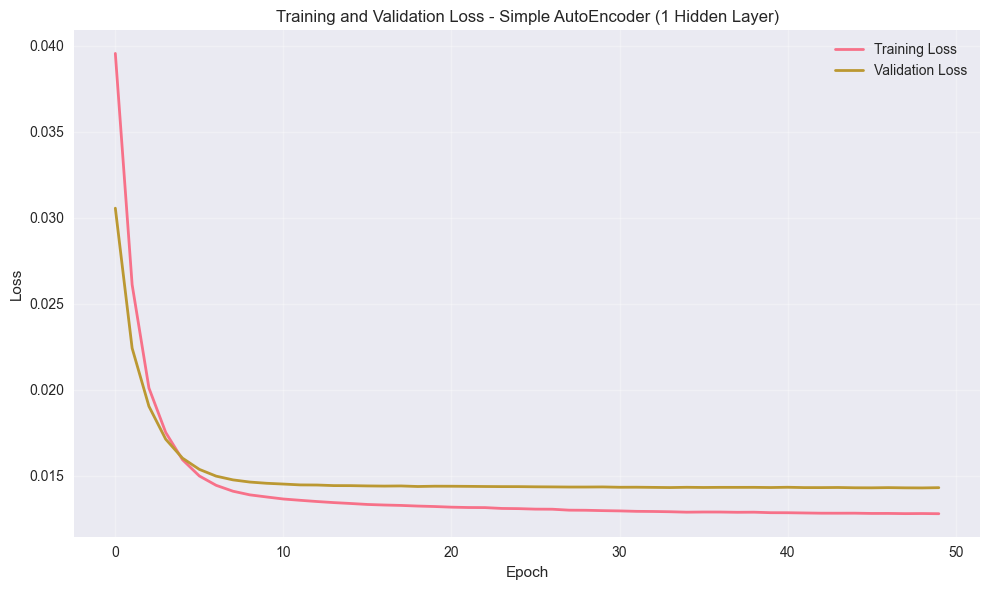


PLOTTING DENOISING PERFORMANCE

Plotting denoising performance for Simple AutoEncoder (1 Hidden Layer)...


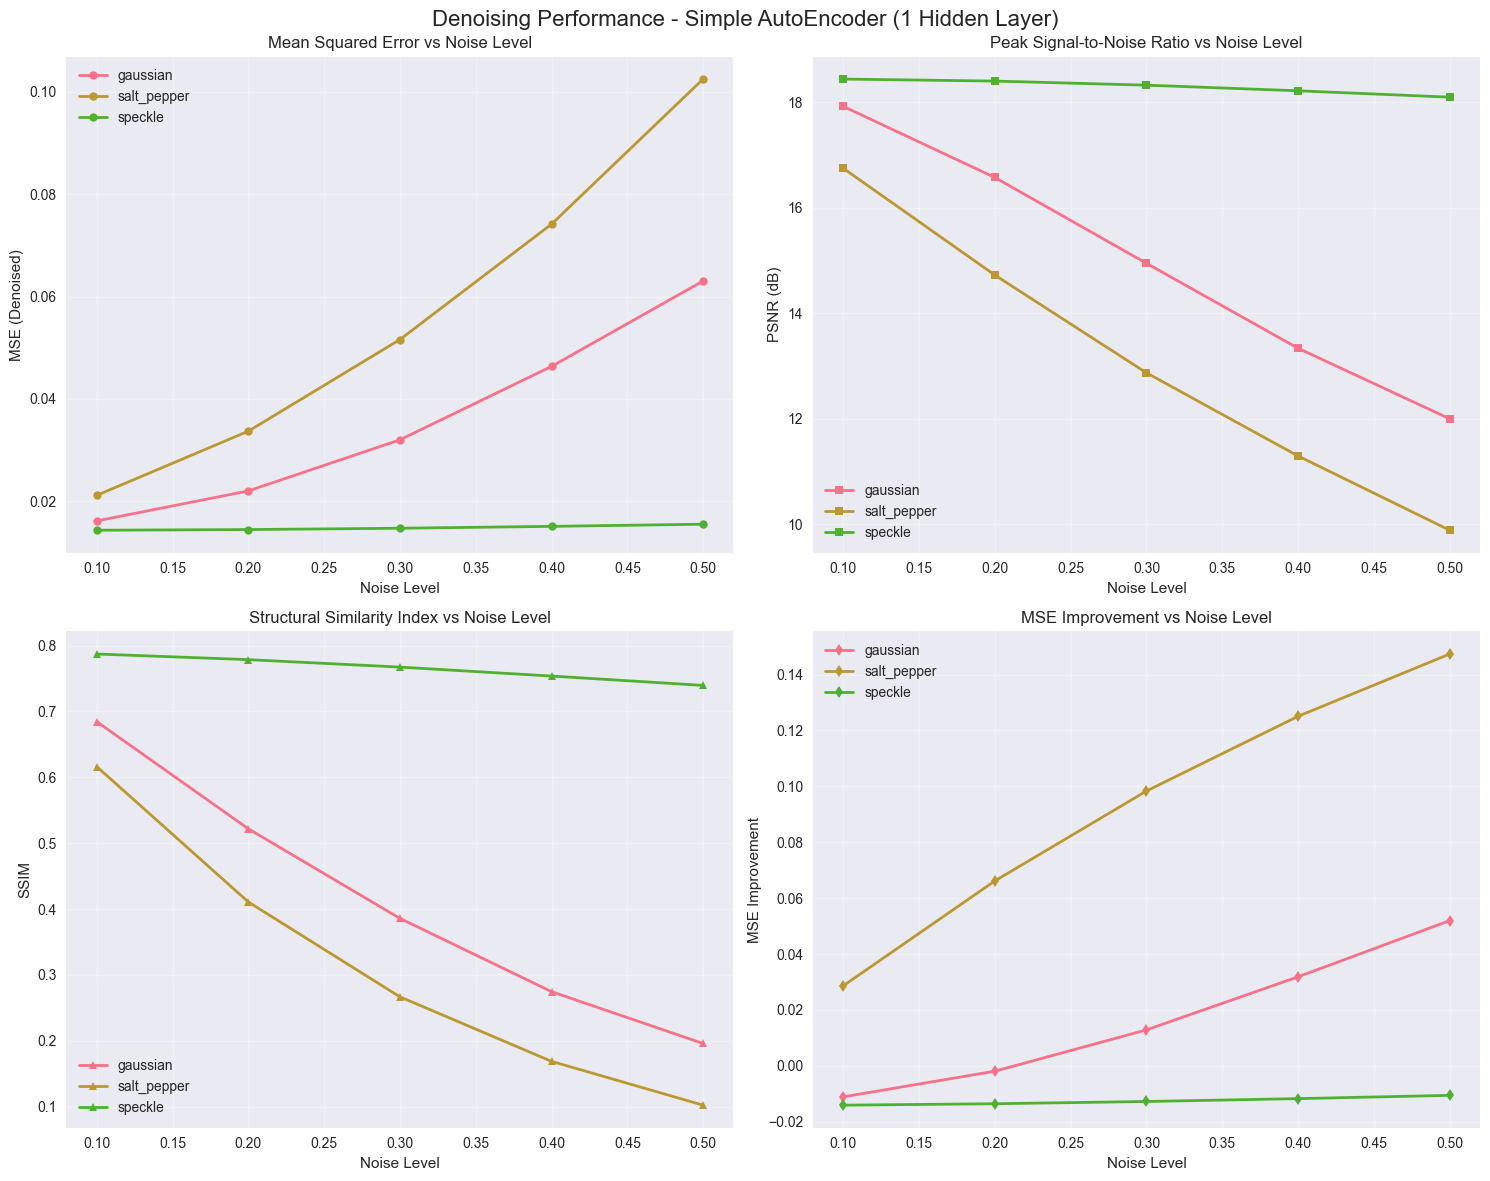


PLOTTING DENOISING SAMPLE RESULTS
Generated 16 test samples with Gaussian noise (level 0.3)

Plotting sample results for Simple AutoEncoder (1 Hidden Layer)...


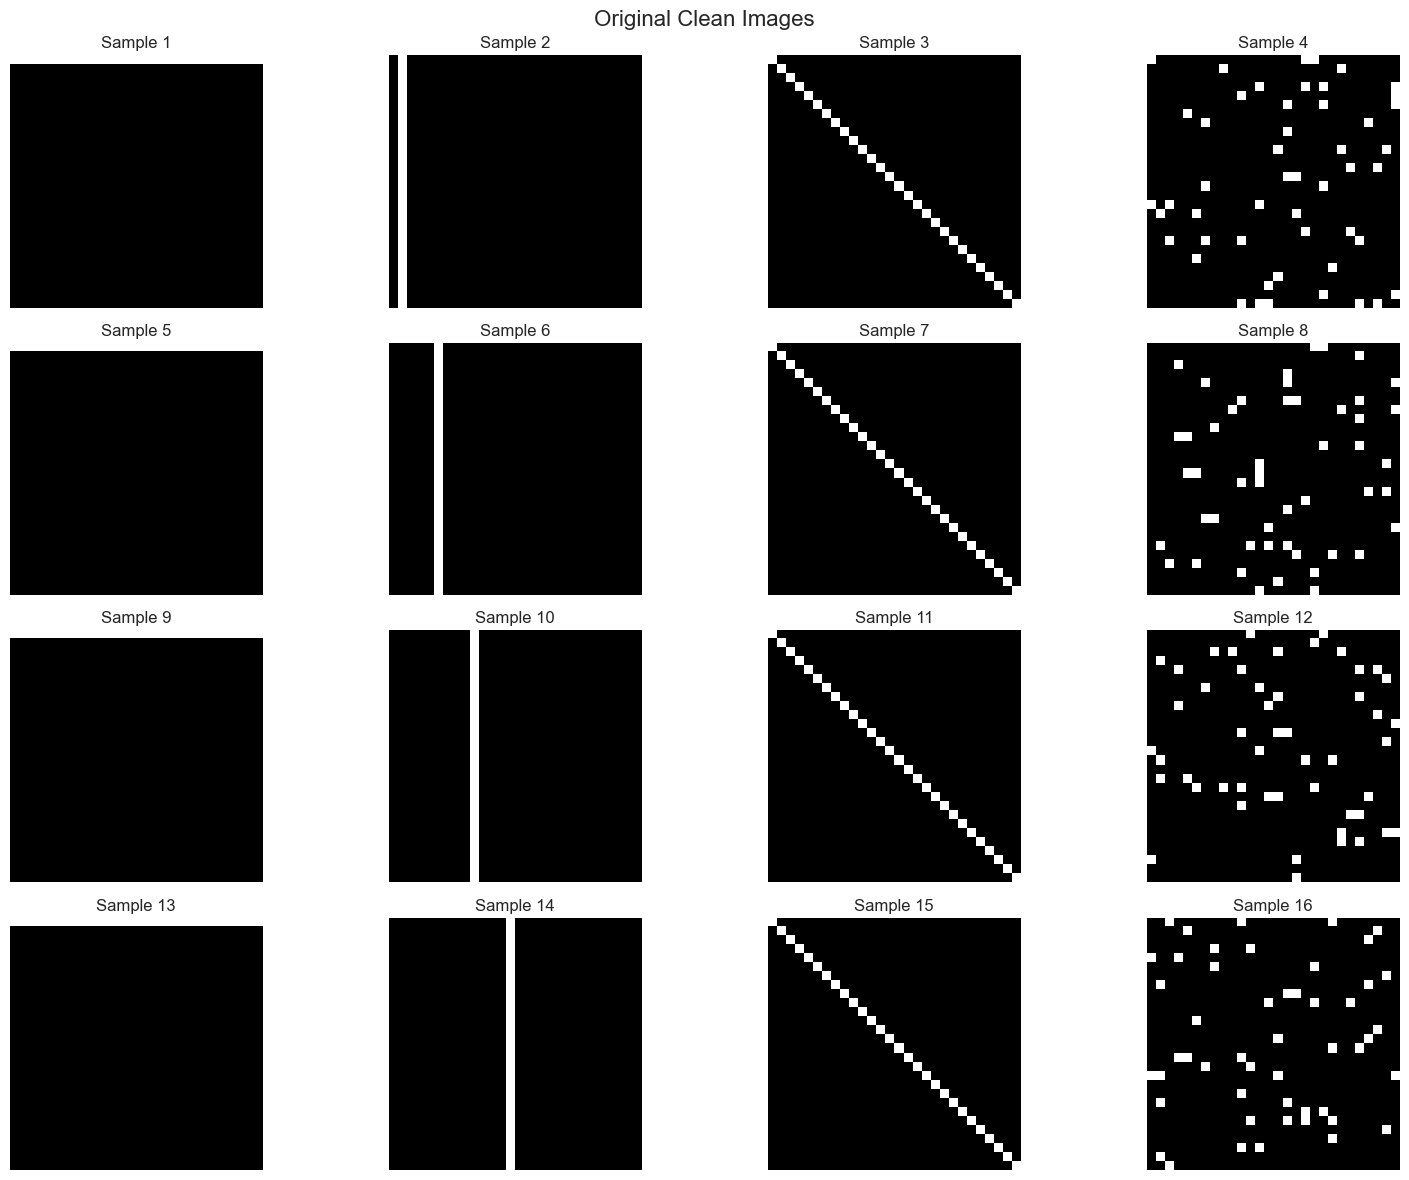

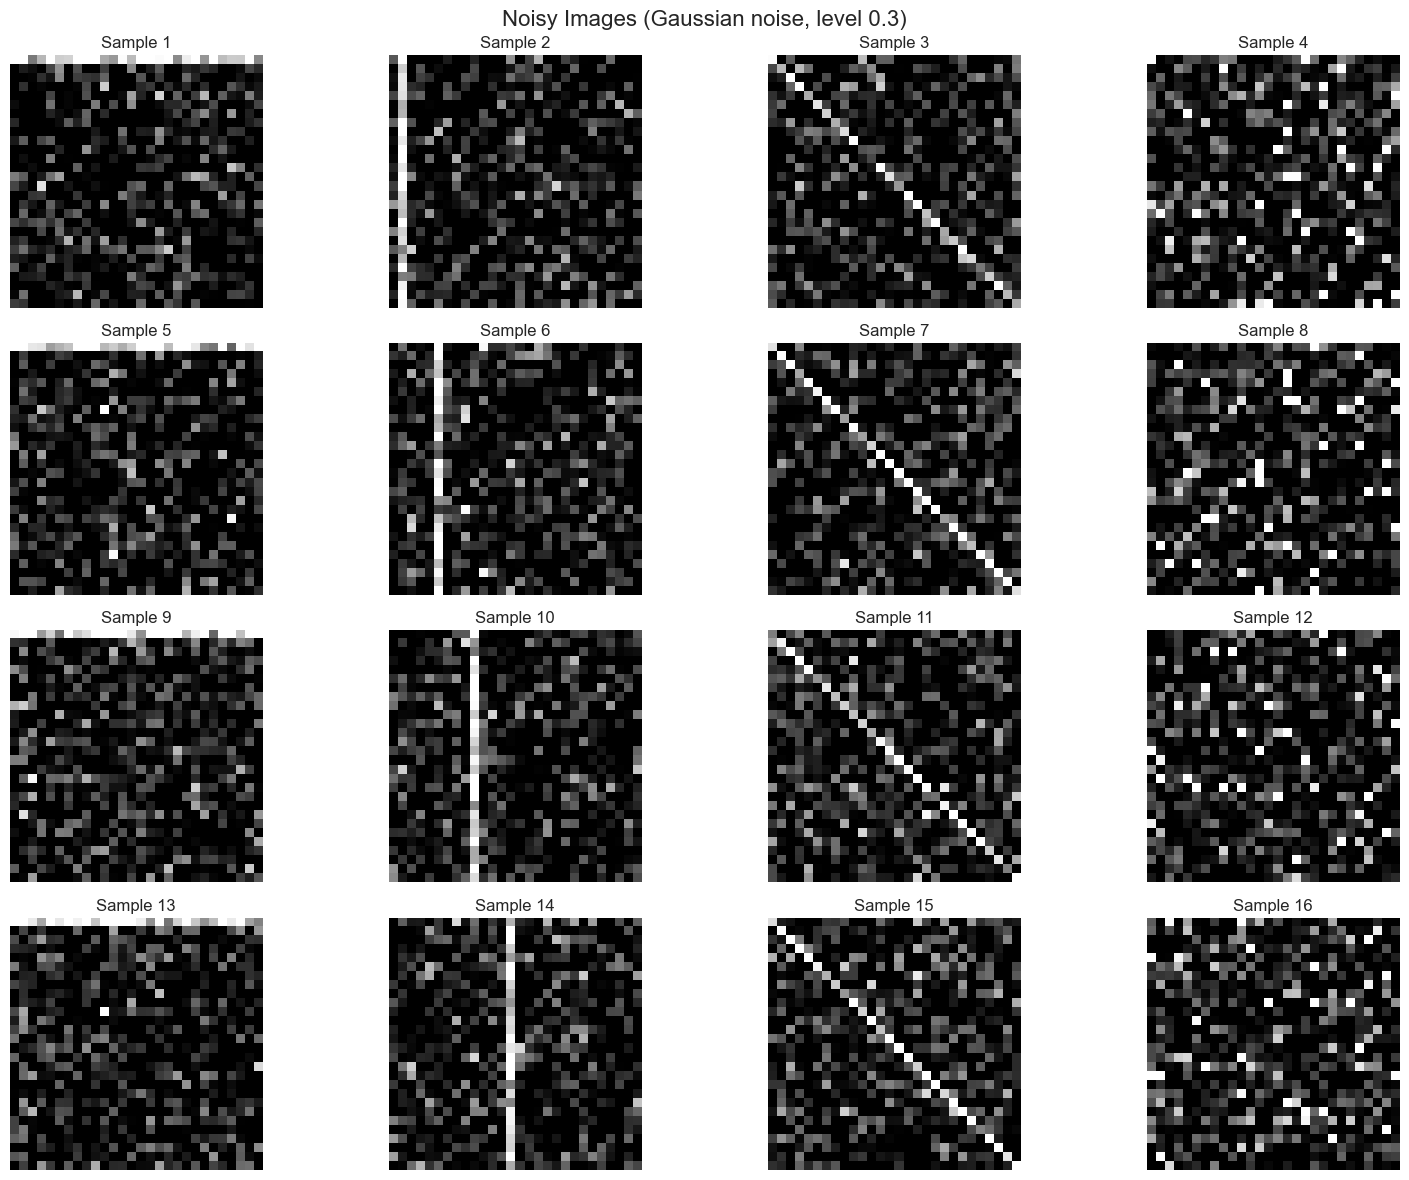

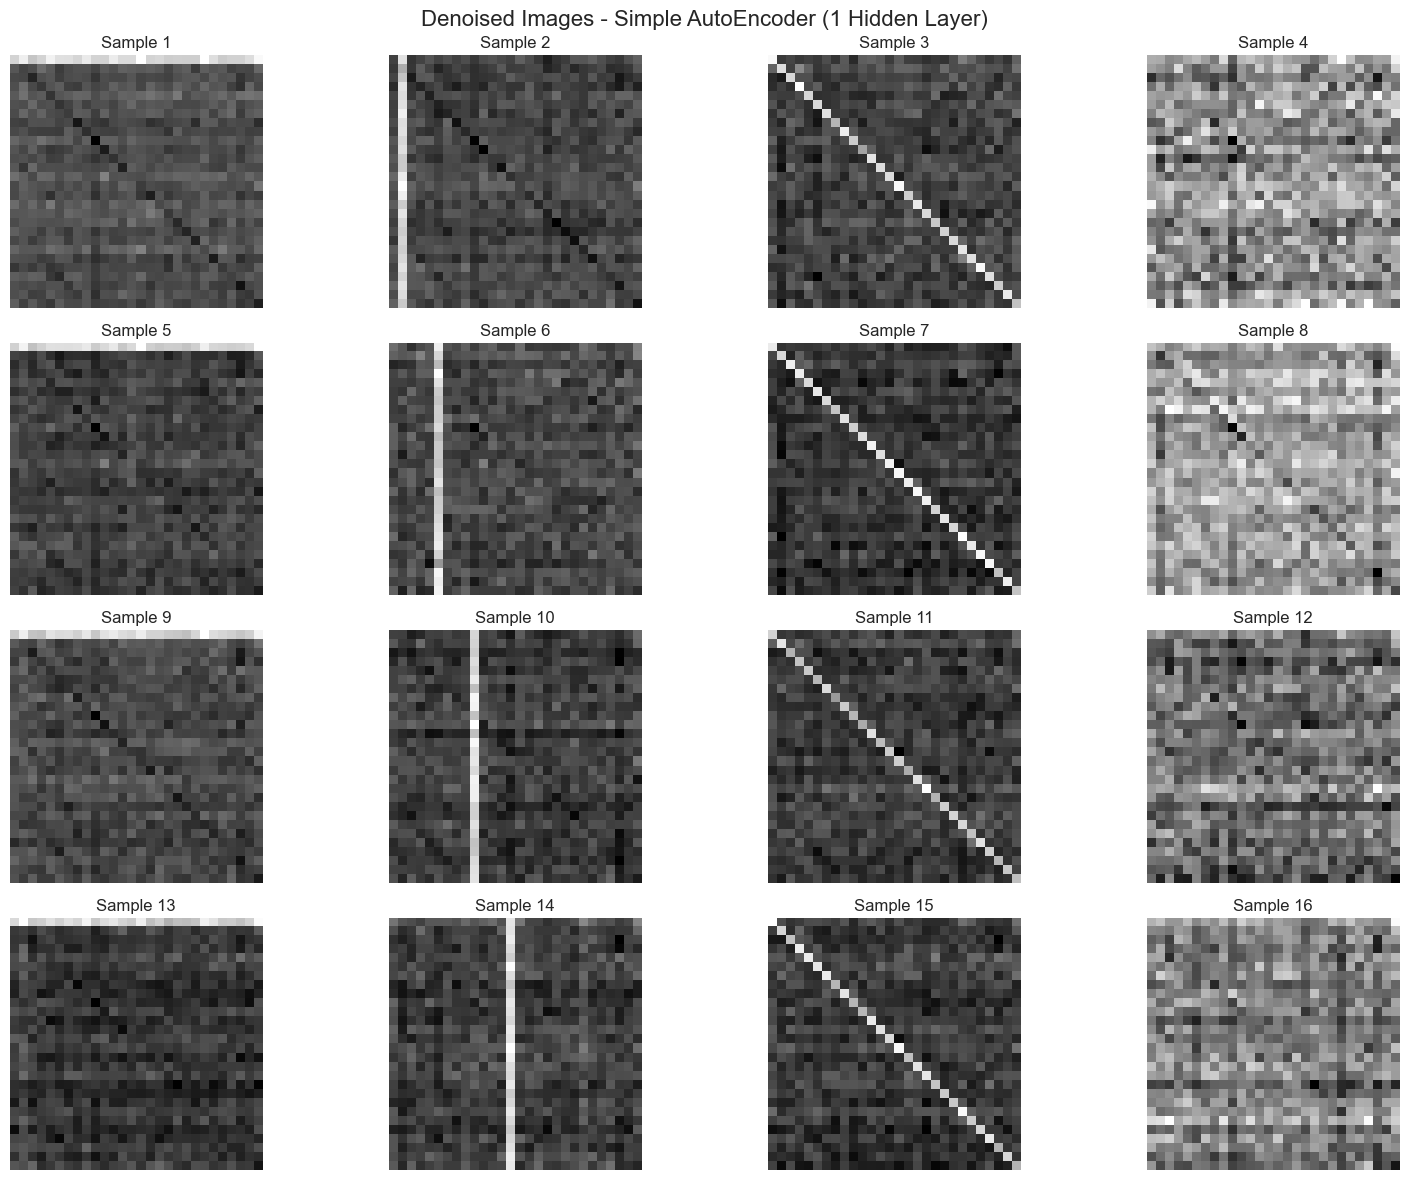

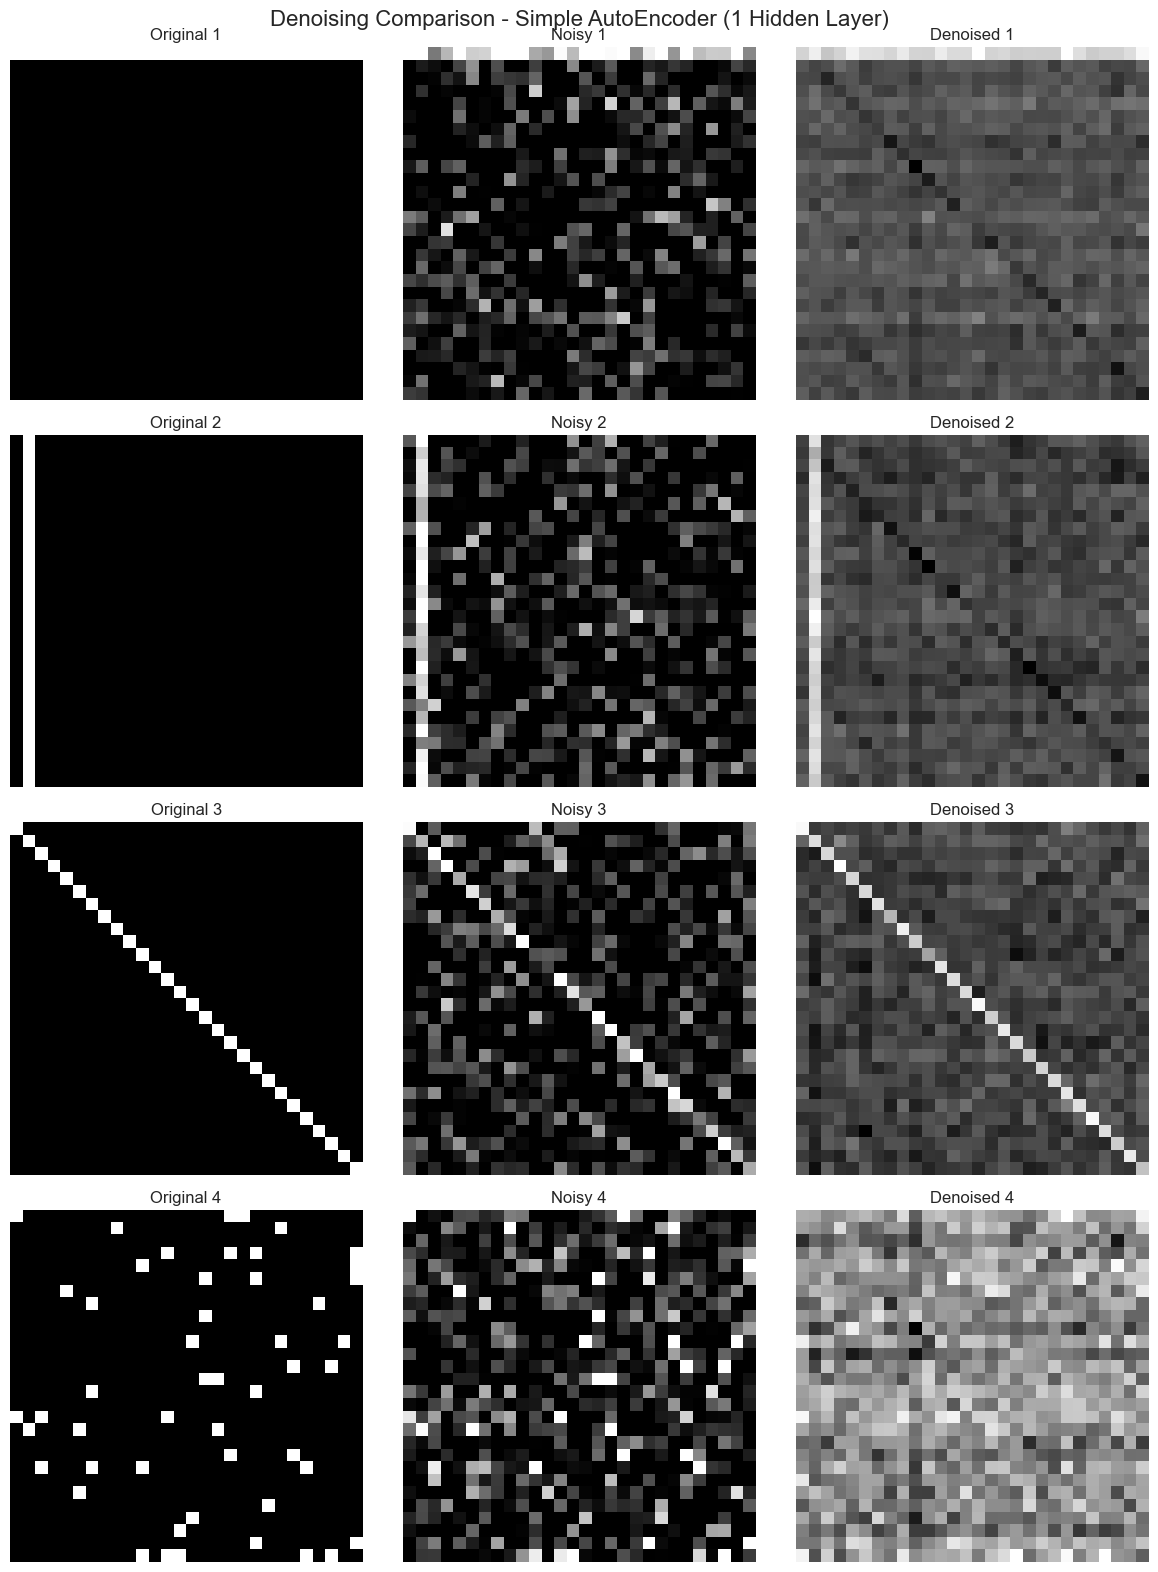


PLOTTING NOISE TYPE COMPARISON

Plotting noise type comparison for Simple AutoEncoder (1 Hidden Layer)...


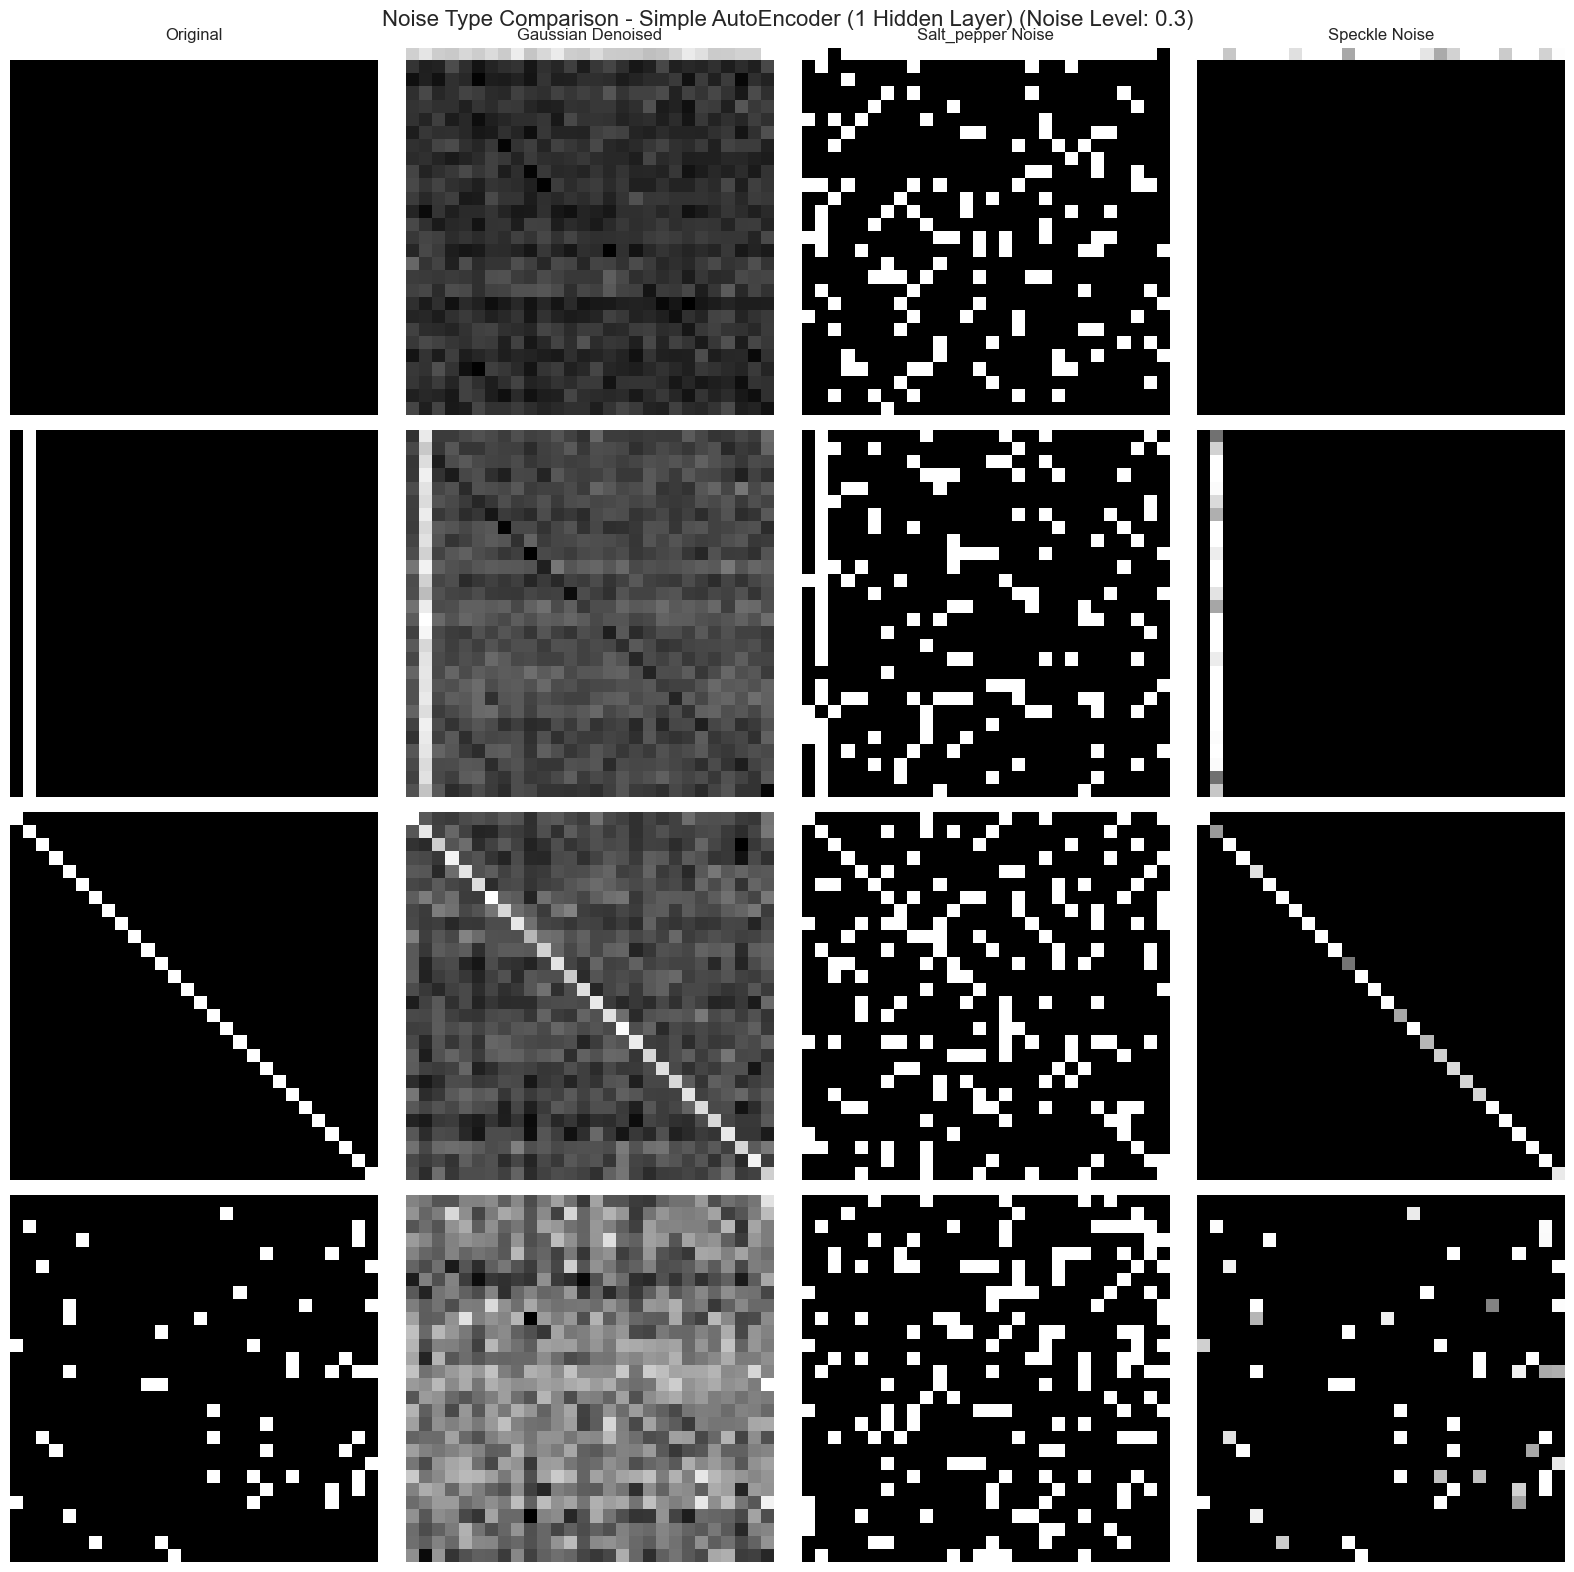

In [10]:
# Create and run experiment
experiment = DenoisingExperiment()

experiment.run_experiment()